In [1]:
import pandas as pd
import ast as ast
import numpy as np
from typing import *
import regex as re
import matplotlib.pyplot as plt
import seaborn as sns


from task_2_helpers import *
from collections import Counter

# from task2_business_KNN import classify_Kmeans


### Data Read

In [2]:
df_data = pd.read_parquet('data/ATML2024_Task2_PhiliBussRatings.parquet', engine='pyarrow')
print(df_data.shape)
print(df_data.columns)

df_data_res = df_data[df_data['categories_list'].apply(lambda x: any('restaurants' in str(a).lower() for a in x)
                       or any('restaurant' in str(a).lower() for a in x))]
print(df_data_res.shape)
df_data_res.head()


(176549, 12)
Index(['business_id', 'postal_code_int', 'attributes_list', 'hours_list',
       'categories_list', 'id', 'rating', 'useful', 'funny', 'cool', 'text',
       'date'],
      dtype='object')
(123414, 12)


,business_id,postal_code_int,attributes_list,hours_list,categories_list,id,rating,useful,funny,cool,text,date
0,wm9eoqjytVbC7dQcM4WSTM,19107.0,"[alcohol, bikeparking, businessacceptscreditca...","[[7.0, 20.0], [7.0, 20.0], [7.0, 20.0], [7.0, ...","[bakeries, bubble tea, coffee & tea, food, res...",100621,4,1,0,2,So I don't know how the other review was doubl...,2017-08-24 04:23:03
1,wm9eoqjytVbC7dQcM4WSTM,19107.0,"[alcohol, bikeparking, businessacceptscreditca...","[[7.0, 20.0], [7.0, 20.0], [7.0, 20.0], [7.0, ...","[bakeries, bubble tea, coffee & tea, food, res...",174063,5,0,0,0,I love this place.. I love their chunky fried...,2020-05-25 16:27:36
2,wm9eoqjytVbC7dQcM4WSTM,19107.0,"[alcohol, bikeparking, businessacceptscreditca...","[[7.0, 20.0], [7.0, 20.0], [7.0, 20.0], [7.0, ...","[bakeries, bubble tea, coffee & tea, food, res...",234948,5,0,0,1,I ordered so many cake from here for our famil...,2019-07-25 13:09:14
3,wm9eoqjytVbC7dQcM4WSTM,19107.0,"[alcohol, bikeparking, businessacceptscreditca...","[[7.0, 20.0], [7.0, 20.0], [7.0, 20.0], [7.0, ...","[bakeries, bubble tea, coffee & tea, food, res...",285755,4,0,0,0,Ordered a birthday cake here for the first tim...,2019-03-12 17:04:09
4,wm9eoqjytVbC7dQcM4WSTM,19107.0,"[alcohol, bikeparking, businessacceptscreditca...","[[7.0, 20.0], [7.0, 20.0], [7.0, 20.0], [7.0, ...","[bakeries, bubble tea, coffee & tea, food, res...",330446,5,1,0,0,This is my favorite bakery in Chinatown! It's ...,2017-09-13 00:38:08


In [3]:
# all_uniq_cat = set(np.concatenate(df_data.categories_list.values).ravel()) #df_data.categories_list.values.flatten()
# all_uniq_attr = set(np.concatenate(df_data.attributes_list.values).ravel()) #df_data.categories_list.values.flatten()

### 2.2 Food Trends and Restaurant styles


In [4]:
business_cat = np.concatenate(df_data.categories_list.values).ravel()
c = Counter(business_cat)

print(f'Total number of distinct categories of business: {len(c)}')

print(f'The most frequest categories : {c.most_common(10)}')

df_data_res = df_data[df_data['categories_list'].apply(lambda x: any('restaurants' in str(a).lower() for a in x)
                       or any('restaurant' in str(a).lower() for a in x))]

print('We select only the restaurant businesses')                                                       
print(df_data_res.shape)                                                    

Total number of distinct categories of business: 1081
The most frequest categories : [('restaurants', 123410), ('food', 47310), ('nightlife', 40206), ('bars', 38164), ('american (new)', 26829), ('breakfast & brunch', 22358), ('american (traditional)', 21800), ('sandwiches', 19789), ('italian', 15313), ('coffee & tea', 14008)]
We select only the restaurant businesses
(123414, 12)


#### 2.2 What is the food trend of Philadelphia

We can analyse the food trends by two ways:

1 -  We have the category information of the restaurants and their rating. We can distribute these ratings among the categories and take an average per category. This approach gives us a generic liking of the certain categories. However, it doesn't show the trend. We also count the number of time a category appeared in the dataset. This shows the interest of the people to the certain style of restaurants. Using the average rating and the frequency we identify the most trendy restaurant catefories

In [5]:
data_cat_ratings =  df_data_res[['id','date','categories_list', 'rating']]
 
data_cat_rating_single = data_cat_ratings.explode('categories_list')

data_cat_rating_single['mean_rating'] = data_cat_rating_single[['categories_list', 'rating']]\
                        .groupby('categories_list')['rating'].transform('mean')

data_cat_rating_single['frequency'] = data_cat_rating_single['categories_list'].map(data_cat_rating_single['categories_list'].value_counts())
data_cat_rating_single['rate_freq_ratio'] = data_cat_rating_single['frequency']/len(data_cat_ratings)

data_cat = data_cat_rating_single[['categories_list', 'frequency', 'mean_rating', 'rate_freq_ratio']]\
            .drop_duplicates(keep='last').rename(columns={'categories_list':'categories'}) #.set_index('date')

data_cat.sort_values(by='frequency', ascending=False, inplace=True)
data_cat.head(15)

,categories,frequency,mean_rating,rate_freq_ratio
176548,restaurants,123410,3.781598,0.999968
176522,food,37842,3.888642,0.306626
176268,nightlife,36472,3.714987,0.295526
176131,bars,35225,3.716082,0.285421
176131,american (new),26829,3.779791,0.217390
176363,breakfast & brunch,22358,3.854280,0.181163
176522,american (traditional),21800,3.593991,0.176641
176522,sandwiches,19789,3.768356,0.160346
176519,italian,15313,3.776334,0.124078
176422,pizza,13967,3.639865,0.113172


In [6]:
data_cat = data_cat[ (data_cat['rate_freq_ratio'] < 0.90) & (data_cat['rate_freq_ratio'] > 0.05) ]

data_cat.sort_values(by='mean_rating', ascending=False, inplace=True)
data_cat.head(18)
# for ind, row in data_cat.iterrows():
#     # print(row)
#     print(f"Catergory: {row.categories} - Rating: {round(row.mean_rating, 2)} - Freq: {row.frequency}")

,categories,frequency,mean_rating,rate_freq_ratio
176519,specialty food,7207,4.072430,0.058397
176363,cafes,7019,4.055706,0.056874
176005,vegetarian,6366,4.024505,0.051582
176160,desserts,6404,4.011555,0.051890
175591,beer,6226,4.008834,0.050448
175591,wine & spirits,6226,4.008834,0.050448
176522,coffee & tea,11148,3.974435,0.090330
175692,japanese,6805,3.907127,0.055140
176522,food,37842,3.888642,0.306626
174802,asian fusion,6733,3.877469,0.054556


In [27]:

chosen_cat=['specialty food', 
       #      'cafes', 
            'vegetarian', 
       #      'desserts', 
       #      'beer','wine & spirits', 
       # 'coffee & tea', 
       'japanese', 
       'asian fusion', 'breakfast & brunch', 'chinese', 
       'salad', 'seafood']

data_cat_rating_chosen = data_cat_rating_single.loc[data_cat_rating_single.categories_list.isin(chosen_cat), ['date','rating', 'categories_list']]\
                            .rename(columns={'categories_list':'categories'})

data_cat_rating_chosen['date'] = pd.to_datetime(data_cat_rating_chosen['date'])

data_cat_rating_chosen = data_cat_rating_chosen[data_cat_rating_chosen['date'] > '2019-01-01']
data_cat_rating_chosen['quarter'] = data_cat_rating_chosen['date'].dt.to_period('Q').astype(str)

# data_cat_rating_chosen['month_year'] = data_cat_rating_chosen['date'].dt.strftime('%m/%Y')
# df_grouped = data_cat_rating_chosen.groupby(['month_year', 'categories']).rating.mean().reset_index()

df_grouped = data_cat_rating_chosen.groupby(['quarter', 'categories']).rating.mean().reset_index()

df_pivot = df_grouped.pivot(index='quarter', columns='categories', values='rating')
df_pivot = df_pivot.sort_index()



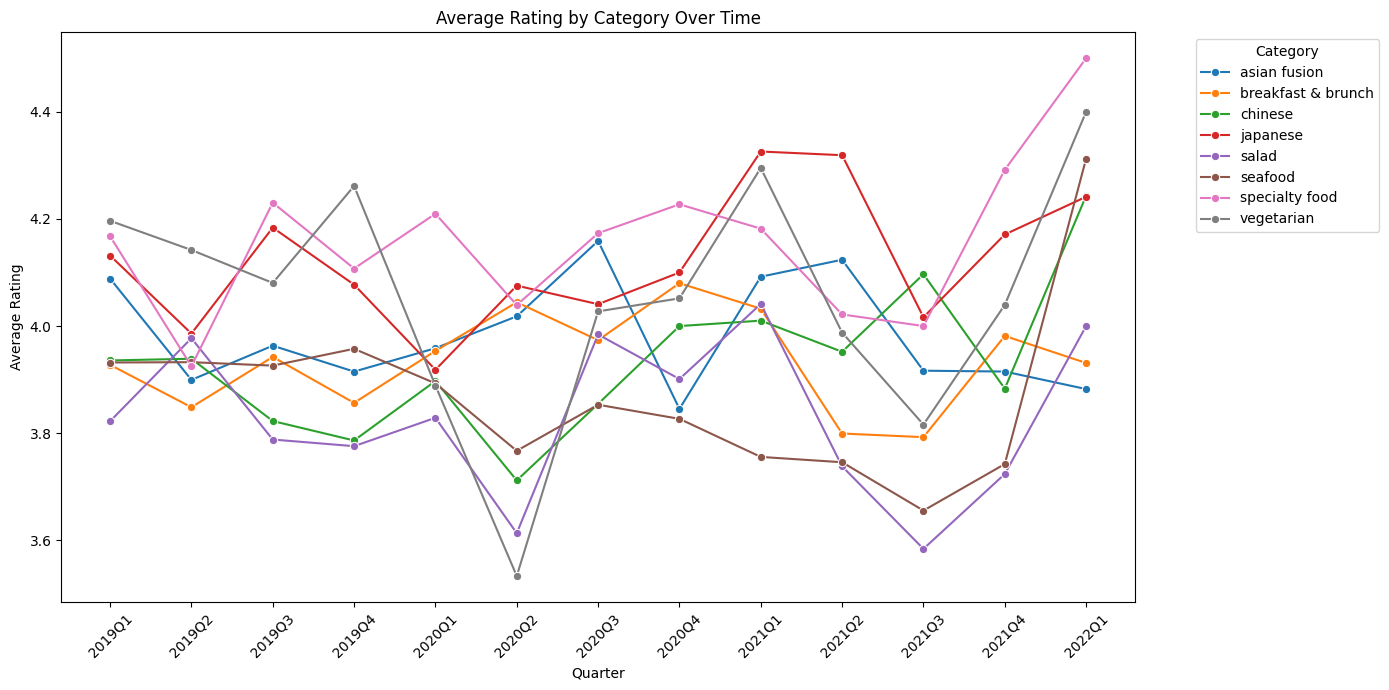

In [29]:
# Plot the data
plt.figure(figsize=(14, 7))

# Create a lineplot with seaborn
sns.lineplot(data=df_grouped, x='quarter', y='rating', hue='categories', marker='o')

# Adjust the legend to be on the side
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')

# Set plot labels and title
plt.xlabel('Quarter')
plt.ylabel('Average Rating')
plt.title('Average Rating by Category Over Time')
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

In [30]:
# import matplotlib.pyplot as plt


# # Plot the data
# plt.figure(figsize=(14, 7))

# for category in df_pivot.columns:
#     plt.plot(df_pivot.index.astype(str), df_pivot[category], label=category)

# # Set plot labels and title
# plt.xlabel('Quarter')
# plt.ylabel('Average Rating')
# plt.title('Average Rating by Category Over Time')
# plt.legend(title='Category')
# plt.xticks(rotation=45)
# plt.tight_layout()

# # Show the plot
# plt.show()

#### 2.3 Suggestions for the restaurants

In [8]:
data_att_ratings =  df_data_res[['id','date','attributes_list', 'rating']]
 
data_att_rating_single = data_att_ratings.explode('attributes_list')
data_att_rating_single['attributes_mean_rating'] = data_att_rating_single[['attributes_list', 'rating']].groupby('attributes_list')['rating'].transform('mean')

data_att = data_att_rating_single[['date', 'attributes_list', 'attributes_mean_rating']]\
            .drop_duplicates(keep='last').rename(columns={'attributes_list':'attributes', 'attributes_mean_rating':'mean_rating'}) #.set_index('date')

data_att.head()

,date,attributes,mean_rating
0,2017-08-24 04:23:03,alcohol,3.785099
0,2017-08-24 04:23:03,bikeparking,3.804002
0,2017-08-24 04:23:03,businessacceptscreditcards,3.781729
0,2017-08-24 04:23:03,businessparking-street,3.867158
0,2017-08-24 04:23:03,byappointmentonly,4.029273
